In [60]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
np.random.seed(1)

In [289]:
def plot_impulses(y,p,r,d,debt,g):
    fig, [[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(6,6))
    ax1.plot(y)
    ax1.set_title('Output gap')
    ax2.plot(p)
    ax2.set_title('Inflation')
    ax3.plot(r)
    ax3.set_title('Interest rate')
    ax4.plot(d)
    ax4.set_title('Debt to public expenditure')
    ax5.plot(debt)
    ax5.set_title('Debt')
    ax6.plot(g)
    ax6.set_title('Government Expenditure')
    plt.tight_layout()
    plt.show()


def model():
    ## Parameters of the model
    mm = 2 #switching parameter gamma in Brock Hommes
    pstar = 0.018
    # the central bank's inflation target
    eprational=1 # if all agents have rational forecast of inflation this parameter is 1
    epextrapol=0 # if all agents use inflation extrapolation this parameter is 1
    a1 = 0.5 #coefficient of expected output in output equation
    a2 = 0.2 #Interest elasticity of output demand
    a3 = 0.25 #Coefficient of public expenditure in output equation
    b1 = 0.5 #b1 is coefficient of expected inflation in inflation equation
    b2 = 0.05 #b2 is coefficient of output in inflation equation
    c1 = 1.5 #c1 is coefficient of inflation in Taylor equation
    c2 = 0.5 #c2 is coefficient of output in Taylor equation
    c3 = 0.5 #interest smoothing parameter in Taylor equation
    f1 = 0.6 #Public expenditure smoothing in fiscal rule
    f2 = 0.4 #Coefficient of output in fiscal rule
    f3 = 0.03 #Coefficient of public debt in fiscal rule
    rs = 0.01 #S.S. interest rate
    h1 = 0.4 #Coefficient of public expenditure in debt equation
    h2 = 1.6 #Coefficient of output in debt equation
    tau = 0.3 #Income tax rate
    rho=0.5 #Memory parameter
        
        
    A = np.array([[1,0,a2,-a3,0],
                  [-b2,1,0,0,0],
                  [-c2,-c1,1,0,0],
                  [0,0,0,1,f3],
                  [0,0,0,0,1]])    
    B = np.array([[a1,a2,0,0,0],
                  [0,b1,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,0]])
    C = np.array([0,0,-c1,0,0])
    D = np.array([[1-a1,0,0,0,0],
                  [0,1-b1,0,0,0],
                  [0,0,c3,0,0],
                  [-f2,0,0,f1,0],
                  [-h2*tau*(1+rs),-(1+rs),1,h1*(1+rs),1+rs]])
    T = 330
    TI = 300
    K = 50
    debt_ss = 0.5
    #length of period to compute divergence
    sigma = np.ones(5)*0.0
    epfs=pstar
    #forecast inflation targeters
    p = np.zeros(T)
    y = np.zeros(T)
    plagt = np.zeros(T)
    ylagt = np.zeros(T)
    r = np.zeros(T)
    epf = np.zeros(T)
    epc = np.zeros(T)
    ep = np.zeros(T)
    ey = np.zeros(T)
    CRp = np.zeros(T)
    FRp = np.zeros(T)
    alfapt = np.zeros(T)
    eyfunt = np.zeros(T)
    CRy = np.zeros(T)
    FRy = np.zeros(T)
    alfayt = np.zeros(T)
    anspirits = np.zeros(T)
    g = np.zeros(T) #government expenditures
    d = np.zeros(T) #deltas
    epsilont = np.zeros(T)
    etat = np.zeros(T)
    ut = np.zeros(T)
    nut = np.zeros(T)
    psit = np.zeros(T)
    debt = np.zeros(T)
    

    #################################################
    #heuristic model
    #################################################
    alfap=0.5
    alfay=0.5
    K1=K+1

    for t in range(1,T):
        epsilont[t]=rho*epsilont[t-1]+sigma[0]*np.random.randn()#shocks in output equation [demand shock]
        etat[t]=rho*etat[t-1]+sigma[1]*np.random.randn()#shocks in inflation equation [supply shock]
        ut[t]=rho*ut[t-1]+sigma[2]*np.random.randn()#shocks in Taylor rule [interest rate shock]
        nut[t]=rho*nut[t-1]+sigma[3]*np.random.randn()
        psit[t]=rho*psit[t-1]+sigma[4]*np.random.randn()
        nut[305]=1
        
        epsilon=epsilont[t]
        eta=etat[t]
        u=ut[t]
        nu = nut[t]
        psi = psit[t]
        shocks = np.array([epsilon,eta,u,nu,psi])
        epcs=p[t-1]
        if eprational==1:
            epcs=pstar

        eps=alfap*epcs+(1-alfap)*epfs
        if epextrapol==1:
            eps=p[t-1]
        # eps is expected inflation in next period
        eychar=y[t-1]
        eyfun=0+1/2
        eyfunt[t]=eyfun
        eys=alfay*eychar+(1-alfay)*eyfun
        forecast=np.array([eps, eys,0,0,0]) # expected inflation, expected y t+1
        ylag=y[t-1]
        plag=p[t-1]
        rlag=r[t-1]
        glag=g[t-1]
        dlag=d[t-1]
        lag=np.array([ylag,plag,rlag,glag,dlag])
        
        Z = np.dot(np.linalg.inv(A),(np.dot(B,forecast)+C*pstar+np.dot(D,lag)+shocks))

        
        y[t]=Z[0]
        p[t]=Z[1]
        r[t]=Z[2]
        g[t]=Z[3]
        d[t]=Z[4]
        #r[t]= (1-c3)*(c1*(p[t])+c2*y[t])+c3*rlag+u
        #if square==1
        #    r[t]=c1*[p[t]]^2+c2*y[t]+c3*r[t-1]+u
        #end
        plagt[t]=p[t-1]
        ylagt[t]=y[t-1]
        CRp[t]=rho*CRp[t-1]-(1-rho)*(epcs-p[t])**2
        FRp[t]=rho*FRp[t-1]-(1-rho)*(epfs-p[t])**2
        CRy[t]=rho*CRy[t-1]-(1-rho)*(eychar-y[t])**2
        FRy[t]=rho*FRy[t-1]-(1-rho)*(eyfun-y[t])**2

        alfap=np.exp(mm*CRp[t])/(np.exp(mm*CRp[t])+np.exp(mm*FRp[t]))
        alfay=np.exp(mm*CRy[t])/(np.exp(mm*CRy[t])+np.exp(mm*FRy[t]))
        alfapt[t]=alfap
        alfayt[t]=alfay
        
        debt[t] = np.exp(d[t]+np.log(debt_ss))
        
        #if eychar>0:
        #    anspirits[t]=alfay
        #if eychar<0:
        #    anspirits[t]=1-alfay
    #return y[TI:],p[TI:],r[TI:],d[TI:]
    return y[TI:]-np.median(y[:TI]),p[TI:]-np.median(p[:TI]),r[TI:]-np.median(r[:TI]),d[TI:]-np.median(d[:TI]),debt[TI:]-np.median(debt[:TI]),g[TI:]-np.median(g[:TI])
_=model()


In [290]:
Nruns = 1
outputs = np.zeros((6,Nruns,30))
for i in range(Nruns):
    ret = model()
    outputs[0,i,:] = ret[0]
    outputs[1,i,:] = ret[1]
    outputs[2,i,:] = ret[2]
    outputs[3,i,:] = ret[3]
    outputs[4,i,:] = ret[4]
    outputs[5,i,:] = ret[5]

In [291]:
medians = np.array([np.median(w,axis=0) for w in outputs])
upper_quartile = np.array([np.percentile(w,q=97.5,axis=0) for w in outputs])
lower_quartile = np.array([np.percentile(w,q=2.5,axis=0) for w in outputs])

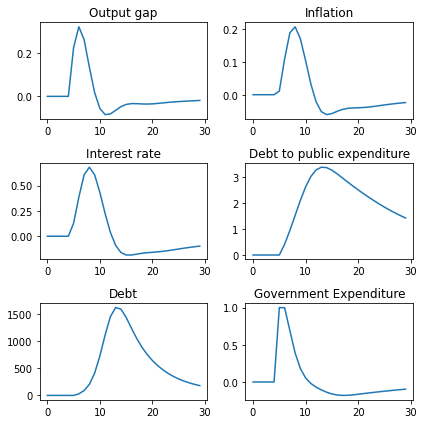

In [292]:
plot_impulses(*medians)